# Part 1

## 1a Forward Euler solver

In [112]:
%load_ext autoreload
%autoreload 2
import util
import scipy as sp
import numpy as np 

def solve_forward_euler(F, G, u_signal, x0, fs):
    """
    Simulates a state-space system using Forward Euler.
    
    Parameters:
    F, G: System matrices
    u_signal: Array of inputs over time
    x0: Initial state vector
    fs: Sampling frequency
    """
    Ts = 1 / fs
    num_steps = len(u_signal)
    
    # 1. Initialize History Arrays
    # We need to store the state at every time step to plot it later.
    # Shape: (Number of Time Steps, Number of States)
    num_states = len(x0)
    x_history = np.zeros((num_steps, num_states))
    
    # Set current state to initial state
    x_curr = x0.copy()
    
    print(f"Simulating {num_steps} steps with Ts={Ts:.10f}s...")

    # 2. The Simulation Loop
    for n in range(num_steps):
        # Store current state
        x_history[n] = x_curr
        
        # Get current input (handle scalar or vector inputs)
        u_curr = u_signal[n]
        
        # --- THE FORMULA FROM YOUR IMAGE ---
        # Calculate the derivative (slope)
        # dx/dt = F*x + G*u
        dx = (F @ x_curr) + (G * u_curr)
        
        # Euler Step: New = Old + (Slope * StepSize)
        x_next = x_curr + (dx * Ts)
        # -----------------------------------
        
        # Update for next iteration
        x_curr = x_next
        
    return x_history

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1b Running forward Euler with linear params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 7023.90
Simulating 35119 steps with Ts=0.0000284746s...


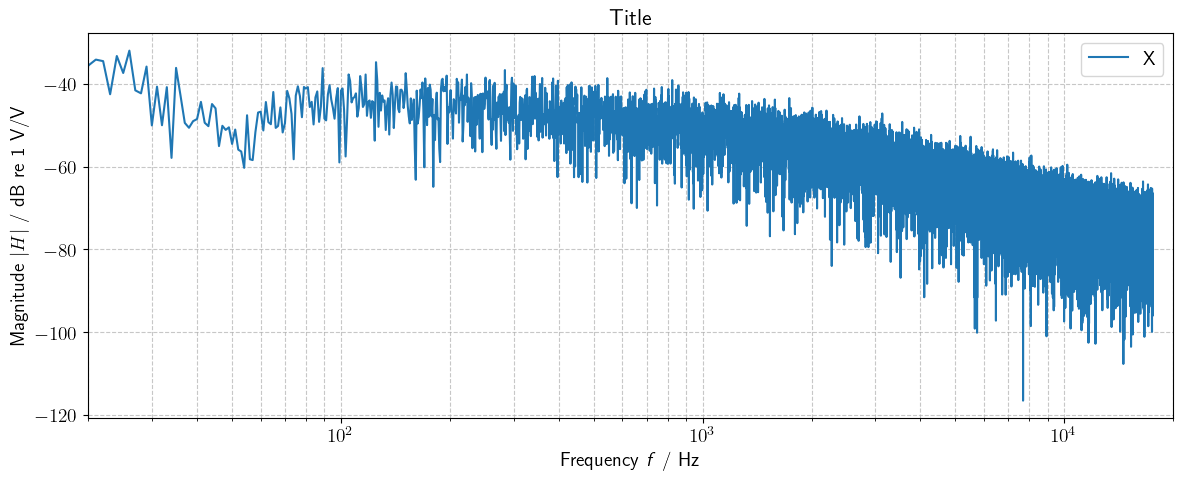

In [117]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt

## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)

pink_noise_20Hz = util.generate_pink_noise(fs*1, fs, fmin=20)

# signal_int16 = np.int16(pink_noise_20Hz / np.max(np.abs(pink_noise_20Hz)) * 32767)
# wavfile.write("signals/pink_noise_20Hz.wav", fs, signal_int16)

x = solve_forward_euler(F, G, pink_noise_20Hz, x0, fs)

f, X, X_dB = util.make_spectrum(x[:,0], fs, scaling=True, oneside=True)

util.plot_mag([f], [X], legends=["X"], title="Title")


## Determine suitable $f_s$

In [38]:
%load_ext autoreload
%autoreload 2

# klippel values (data/params.txt)
Bl=6.835564595969286
R_e=4.7800112854066175
R_m=2.499311244682717
K_m=1071.063439485575
L_e=0.0003256807665922887
M_m=0.019658990712765827

  
# example values from slides
R_e, L_e, Bl, M_m, R_m, K_m = 5, 0.0006, 7, 18e-3, 2, 1/0.0007


F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

recommended_fs = util.calculate_min_fs(F)
print(recommended_fs)

util.check_stability(F, recommended_fs) 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3869.6821589946794
checking fs=3869.7 Hz => max eigenvalue magnitude: 1.0000


False

In [ ]:

# X = F + u*G
# state vector
# X = np.array([
#     i_n,
#     d_n,
#     v_n
# ])

# system matrix
F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

# input matrix
G = np.array([
    [1.0/L_e],
    [0.0],
    [0.0]
])


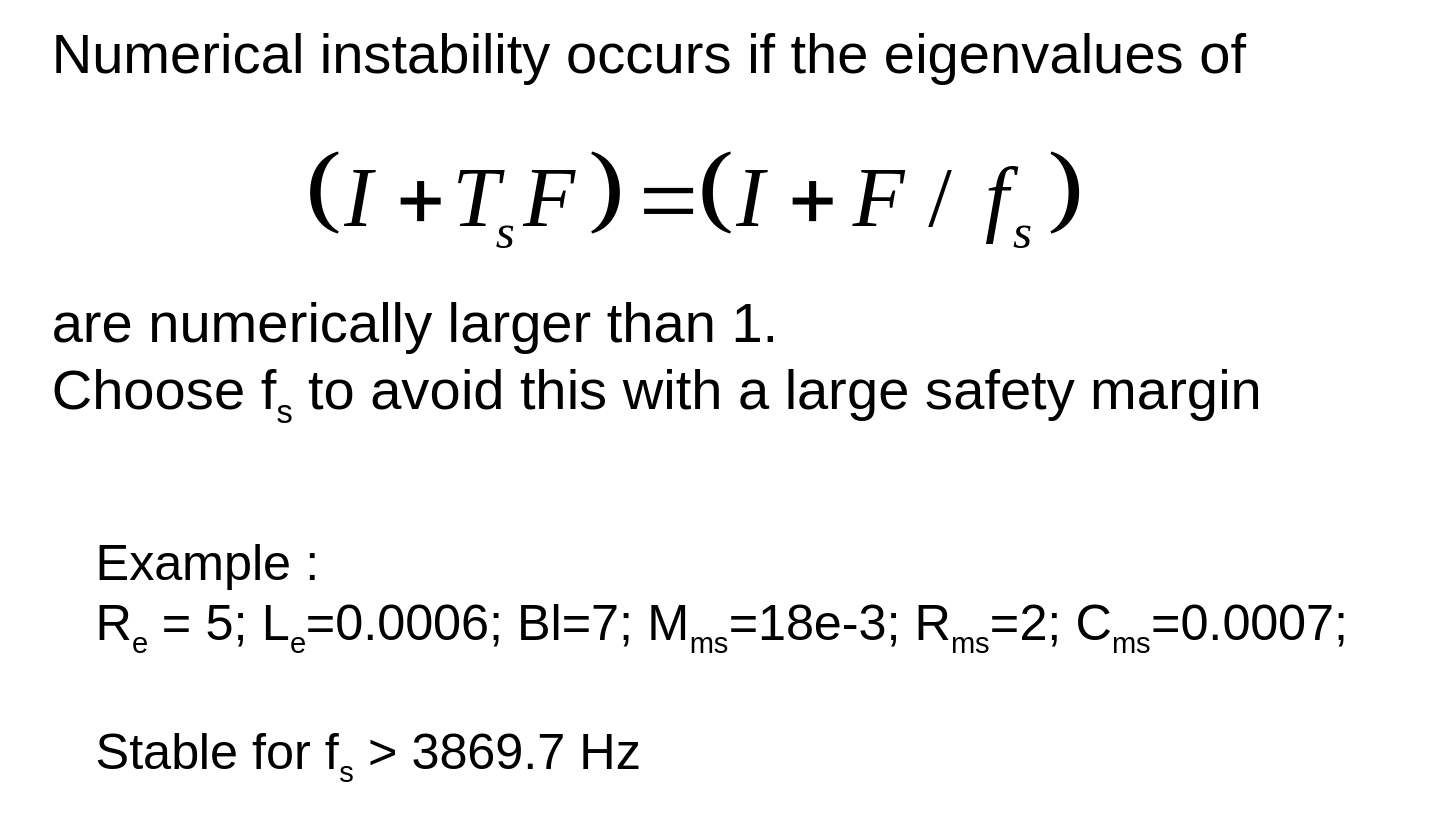